## Introduction to SpaCy
SpaCy is one of the main libraries for NLP in Python. It is especially tailored towards the (development and) deployment of pipelines for a number of NLP tasks, from named entity recognition to dependency parsing. Recent additions to spaCy also make it possible to use advanced models (LLMs) as building block for such pipelines. 

In this notebook, we will explore some of SpaCy's basic functionality. As we will mainly focus on understanding and implementing methods to represent and generate text, we will not be using SpaCy extensively for the rest of the course -- but it is a great tool for many applications, and it has wonderful documentation.

Let's start by importing SpaCy.
You may need to install this first (I am using `spacy==3.6.1`) -- add it to your requirements file if you have one.

In [3]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from collections import defaultdict
from sklearn.decomposition import PCA

When spaCy is loaded, we then need to initialize a model.

NB: Models first have to be downloaded from the command line. An overview of avaiable models from spaCy can be found [here](https://spacy.io/usage/models):
```
python -m spacy download en_core_web_md
```
Note that models for a wide range of languages are available on SpaCy, feel free to experiment!

In [4]:
nlp = spacy.load("en_core_web_md")

We first create a `spaCy` pipeline which is going to be used for all of our analysis. Essentially we feed our examples of language down the pipeline, and get annotated texts out the end. Let's load the first 10 chapters of "War and Peace", the text file we worked with last week.

In [5]:
book = open('../data/book-war-and-peace.txt').read()

In [ ]:
print(book)

Let's now find where chapter 10 starts, and only keep text until there.

In [7]:
chap_10_index = re.search('CHAPTER X', book).start()
book = book[:chap_10_index]

The final object that comes out of the end is known as a `spaCy` `Doc` which is essentially a list of tokens. However, rather than just being a list of strings, each of the tokens in this list have their own attributes, which can be accessed using the dot notation.

In [8]:
doc = nlp(book)

The resulting `doc` parses the text in sentences and tokens within sentences.

In [ ]:
for s in doc.sents:
    print(s)
    for t in s:
        print(t)

Each token in the doc is annotated for a number of attributes.

In [ ]:
i = 0
for token in doc:
    i += 1
    print(token.text, "\t\t", token.pos_, "\t\t", token.dep_,"\t\t", token.lemma_, "\t\t")
    if i == 50:
        break

### Exploring named entities

Let's explore one of the features of spaCy: named entity recognition. These are all the named entities spaCy finds in the text.

In [ ]:
doc.ents

SpaCy also has some nice utils to visualize like named entities or dependency relations between individual words (try replace `ent` with `dep`). Let's see how this looks:

In [ ]:
spacy.displacy.serve(doc[:300], style="ent")

Now let's try to look at the frequency of each entity, and see what information we can extract on the characters named in the book.

In [14]:
entity_counts = defaultdict(lambda: 0)
for e in doc.ents:
    if e.label_ == 'PERSON':
        entity_counts[e.text] += 1

In [15]:
import pandas as pd
entity_df = pd.DataFrame.from_dict(entity_counts, 
                                   orient='index').reset_index()
entity_df = entity_df.rename({'index': 'entity', 0: 'count'}, axis=1).sort_values(by='count', ascending=False)

In [16]:
entity_df

,entity,count
29,Pierre,98
5,Anna Pavlovna,55
43,Prince Andrew,39
84,Dolokhov,26
36,Prince Hippolyte,16
...,...,...
73,Uncle,1
74,Prince Andrew\nslowly,1
78,comme il\nfaut,1
79,Vasili Kuragin's,1


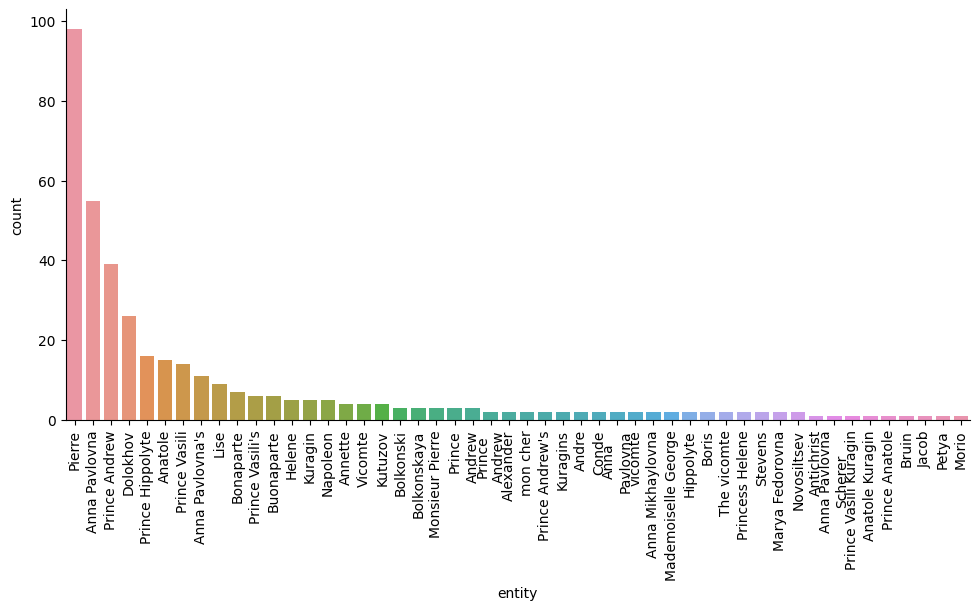

In [17]:
sns.catplot(data=entity_df.head(n=50), x='entity', y='count', kind='bar', height=5, aspect=2)
plt.xticks(rotation=90)
plt.show()

We have a pretty accurate model of who they main characters in War and Peace are! You may notice that some entities are actually duplicates (`Anna Pavlovna` and `Anna Pavlovna's`: these could in principle be manually normalized or, more elegantly, clustered using pipelines for a task called "coreference resolution"). 

### Character time series
As a demonstration of what you can do with this, let's focus on the top 3 characters. Can we plot a time series, visualizing how many times they are mentioned in each of the 9 chapters?

In [18]:
idxs = []
for t in doc:
    if t.text == 'CHAPTER':
        idxs.append(t.idx) # append start index of the chapter

In [20]:
char_count_by_chapter = dict(zip(entity_df.entity.head(n=3).tolist(),
                                 [dict(zip(range(1,10),[0]*9)),
                                  dict(zip(range(1,10),[0]*9)),
                                  dict(zip(range(1,10),[0]*9))])) # there are more elegant ways to do this, with defaultdict

for e in doc.ents:
    if e.text in char_count_by_chapter.keys():
        for nr, i in enumerate(idxs):
            if e.start_char < i:
                char_count_by_chapter[e.text][nr] += 1 # is this correct?
                break
            else:
                if nr == 8:
                    char_count_by_chapter[e.text][9] += 1


In [26]:
char_count_by_chapter

{'Pierre': {1: 0, 2: 6, 3: 4, 4: 9, 5: 15, 6: 12, 7: 12, 8: 14, 9: 26},
 'Anna Pavlovna': {1: 9, 2: 10, 3: 13, 4: 4, 5: 13, 6: 6, 7: 0, 8: 0, 9: 0},
 'Prince Andrew': {1: 0, 2: 0, 3: 0, 4: 5, 5: 7, 6: 10, 7: 8, 8: 8, 9: 2}}

In [27]:
dfs = []
for k,v in char_count_by_chapter.items():
    df = pd.DataFrame.from_dict(v, orient='index').reset_index().rename({'index': 'chapter',
                                                                         0: 'count'}, axis=1)
    df['character'] = k
    dfs.append(df)
char_df = pd.concat(dfs)

In [28]:
char_df

,chapter,count,character
0,1,0,Pierre
1,2,6,Pierre
2,3,4,Pierre
3,4,9,Pierre
4,5,15,Pierre
5,6,12,Pierre
6,7,12,Pierre
7,8,14,Pierre
8,9,26,Pierre
0,1,9,Anna Pavlovna


<Axes: xlabel='chapter', ylabel='count'>

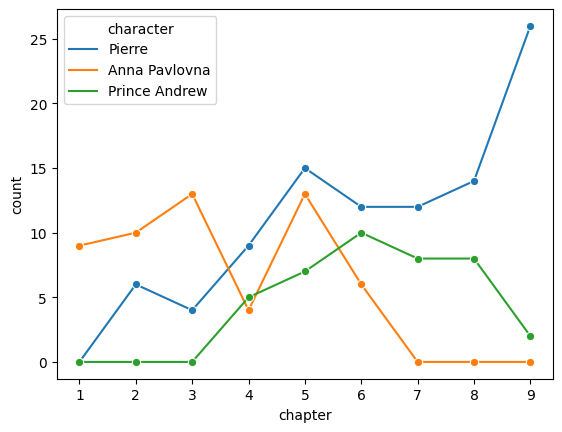

In [29]:
sns.lineplot(data=char_df, x='chapter', y='count', hue='character', marker='o')

## Word vectors
One of the attributes that spaCy models provide is easy access to word vectors. These are not based on counts, but on more sophisticated algorithms that we will look into in detail next week, but the intuition is the same as count-based vectors. Let's use this to put some of the notions we explored in our lecture into practice. First, let's take a look at some of the tokens in our text

In [30]:
for i, t in enumerate(doc[:20]):
    print(i, t.text)

0 CHAPTER
1 I
2 


3 "
4 Well
5 ,
6 Prince
7 ,
8 so
9 Genoa
10 and
11 Lucca
12 are
13 now
14 just
15 family
16 estates
17 of
18 the
19 



Let's focus on the token "family" (occurring, e.g., at index 15). We want to identify the words that are most similar to family (of those present in the text). With SpaCy, we can compute cosine similarity between vectors using in-build functionality. The following piece of code computes the similarity between "family" (the token at index 15) and "estates" (the token at index 16).

In [31]:
doc[15].similarity(doc[16])

0.5541646480560303

Based on this, can you identify the 20 tokens, of those occurring in our doc, whose vectors are *most similar* to "family"? Do the results make sense?

In [71]:
T = len(doc)
texts = []
similarities = []

for t in range(T):
    text = doc[t].text
    similarity = doc[15].similarity(doc[t])

    texts.append(text)
    similarities.append(similarity)

/tmp/ipykernel_3913/3626264805.py:7: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  similarity = doc[15].similarity(doc[t])


In [72]:
simi_df = pd.DataFrame({'token': texts, 'similarity': similarities})
simi_df

,token,similarity
0,CHAPTER,-0.044173
1,I,0.090251
2,\n\n,0.000000
3,"""",-0.024137
4,Well,0.102158
...,...,...
18203,room,0.251319
18204,with,0.326592
18205,it,0.135242
18206,.,0.251326


In [74]:
simi_df = simi_df.sort_values(by='similarity', ascending=False)
simi_df = simi_df.drop_duplicates(subset='token')
simi_df[:21]

,token,similarity
2625,family,1.000000
1311,families,0.742623
3156,mother,0.670364
7386,father,0.669876
369,grandfathers,0.653718
13825,friends,0.610817
2425,brother,0.591992
2339,fathers,0.590159
7634,mothers,0.583737
7388,friendship,0.572327


This looks very promising: can you do the same with other words? What happens if you look at the *most dissimilar* words?

In [75]:
simi_df[-21:]

,token,similarity
9999,gloomy,-0.106515
1581,Funke,-0.106777
18121,Wait,-0.107927
292,7,-0.109517
294,10,-0.110373
12752,de-,-0.111380
2727,femme,-0.111893
1863,bump,-0.113940
1666,Do,-0.114494
10531,gasps,-0.140330


Finally, let's visualize some vectors. Let's sample 200 random nouns, reduce the vector dimensionality with a technique called principal component analysis, and let's visualize the resulting space.

In [ ]:
random_indices = []
for i, t in enumerate(doc):
    if t.pos_ == 'NOUN':
        random_indices.append(i)
        if len(random_indices) == 200:
            break

In [ ]:
pca = PCA(n_components=2)
vectors = np.vstack([doc[i].vector for i in random_indices])
reduced_vectors = pca.fit_transform(vectors) # transform into a 2d space

In [ ]:
reduced_vectors

Now let's plot the reduced vectors in 2D space:

In [ ]:
plt.subplots(figsize=(20,20))
sns.scatterplot(x=reduced_vectors[:200,0], y=reduced_vectors[:200,1])
for i in range(200):
    plt.text(reduced_vectors[i,0], 
             reduced_vectors[i,1], 
             doc[random_indices[i]])

Do you notice anything promising in terms of relations between vectors?

Note that you can also use `scikit-learn` to compute `euclidean_distances` and `cosine_similarity`, see: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise. These functions require a matrix as input, and they compute all pairwise similarities between rows of the matrix.

**Optional**: can you implement your own versions functions to compute euclidean distance and cosine similarity? Look at the formulas from Lecture 2, and use `spaCy` or `scikit-learn` functions to check that they are correct. We will experiment more with word vectors next week.

## Task
In the shared data drive on UCloud, there is a folder called `data`, where you can find a file called `News_Category_Dataset_v2.json`. This is taken from [this Kaggle exercise](https://www.kaggle.com/datasets/rmisra/news-category-dataset) and comprises some 200k news headlines from [HuffPost](https://www.huffpost.com/). The data is a json lines format, with one JSON object per row. You can load this data into pandas in the following way:
```
data = pd.read_json(filepath, lines=True)
```
Select a couple of sub-categories of news data and use spaCy to find the relative frequency per **10k words** of each of the following word classes - NOUN, VERB, ADJECTIVE, ADVERB (in the headlines).
Save the results as a CSV file (again using pandas).
Are there any differences in the distributions?